# Analysis of Model flowerclass-efficientnetv2-2 2: with Image Visualizations

### Goals

* Analysis of the top 8 worst performing classes
* Leverage simple image visualizations to gain insight into algorithm


In [1]:
import math, re, os
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)
print(tfa.__version__)

from flowerclass_read_tf_ds import get_datasets, display_batch_by_class, display_batch_of_images #, load_dataset, display_batch_of_images, batch_to_numpy_images_and_labels, display_one_flower
import tensorflow_hub as hub
import pandas as pd
import math
import plotly_express as px
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

2.6.2
0.14.0
Tensorflow version 2.6.2


In [2]:
tf.test.gpu_device_name()

2022-03-23 14:34:18.447633: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-23 14:34:18.510124: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-23 14:34:18.511380: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-23 14:34:18.512215: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

'/device:GPU:0'

# I. Data Loading

In [3]:
image_size = 224
batch_size = 64

In [4]:
class_names = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102
len(class_names)

104

# II. Model Loading and Predictions: EfficientNetV2

In [5]:
effnet2_base = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2"

In [6]:
    effnet2_tfhub = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=(image_size, image_size,3)),
    hub.KerasLayer(effnet2_base, trainable=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(104, activation='softmax')
])
effnet2_tfhub.build((None, image_size, image_size,3,)) #This is to be used for subclassed models, which do not know at instantiation time what their inputs look like.


effnet2_tfhub.summary()

2022-03-23 14:34:23.813224: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-23 14:34:23.814076: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-23 14:34:23.814704: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-23 14:34:23.815615: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-23 14:34:23.816293: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              20331360  
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               133224    
Total params: 20,464,584
Trainable params: 133,224
Non-trainable params: 20,331,360
_________________________________________________________________


In [7]:
best_phase = 12
effnet2_tfhub.load_weights("../input/flowerclass-efficientnetv2-2/training/"+"cp-"+f"{best_phase}".rjust(4, '0')+".ckpt")

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

Ensure that validation data loader returns fixed order of elements.

In [9]:
ds_train, ds_valid, ds_test = get_datasets(BATCH_SIZE=batch_size, IMAGE_SIZE=(image_size, image_size), 
                                           RESIZE=None, tpu=False, with_id=True)

img_preds = []
img_labels = []
img_ids = []
for imgs, label, imgs_id in tqdm(ds_valid):
    img_preds.append(effnet2_tfhub.predict(imgs, batch_size=batch_size))
    img_labels.append(label.numpy())
    img_ids.append(imgs_id.numpy())
    
img_preds = np.concatenate([img_pred.argmax(1) for img_pred in img_preds])
img_labels = np.concatenate([img_label.argmax(1) for img_label in img_labels])
img_ids = np.concatenate([img_id for img_id in img_ids])


Training: <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 104), (None,)), types: (tf.float32, tf.float32, tf.string)>
Validation: <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 104), (None,)), types: (tf.float32, tf.float32, tf.string)>
Test: <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.string)>


0it [00:00, ?it/s]2022-03-23 14:34:37.710244: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-23 14:34:40.522944: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
58it [00:41,  1.41it/s]


In [10]:
val_results = pd.DataFrame({'pred': img_preds, "label":img_labels, "id": img_ids})
val_results['id'] = val_results['id'].apply(lambda txt: txt.decode())

In [11]:
val_results.head()

pred  label         id
0    62     62  34dfc29ae
1    75     75  83c7db008
2     0      0  1eccb53ac
3    59     59  d76c017b1
4    45     45  d63a88e8f

# III. Analysis of low-performant classes

In [12]:
worst_classes = pd.DataFrame({'class':['globe-flower', 'clematis', 'canterbury bells', 'mexican petunia',
                'black-eyed susan', 'peruvian lily']})

In [13]:
class_names_mapping = {value:key for key, value in  enumerate(class_names)}

In [14]:
worst_classes['idx'] = worst_classes['class'].map(class_names_mapping)
worst_classes

class  idx
0      globe-flower   15
1          clematis   81
2  canterbury bells    2
3   mexican petunia   97
4  black-eyed susan   62
5     peruvian lily   17

In [15]:
conf_matrix = confusion_matrix(val_results['label'], val_results['pred'])

In [16]:
val_results_classes = val_results[(val_results['pred'].isin(worst_classes['idx'])) | (val_results['label'].isin(worst_classes['idx']))]
val_results_classes.shape

(101, 3)

In [17]:
val_results_classes.head()

pred  label         id
0      62     62  34dfc29ae
43      2     18  b0d2f5a65
67     97     97  b4ea454bd
190    81     81  52573f4dd
199    62     62  2069ff5db

# IIIa). globe-flower

In [18]:
class_name = 'globe-flower'

In [19]:
val_results_class = val_results[(val_results['pred'] == class_names_mapping[class_name]) | (val_results['label'] == class_names_mapping[class_name])].copy()

class_names_mapping_inv = {class_names_mapping[name]:name for name in class_names_mapping}
for el in ['pred', 'label']:
    val_results_class.loc[:, f"{el}_class"] = val_results_class[el].map(class_names_mapping_inv)

In [20]:
val_results_class

pred  label         id    pred_class   label_class
1054    15     15  3307d2e97  globe-flower  globe-flower
1174    15     15  eed62e9a4  globe-flower  globe-flower
1618    15     15  77913415c  globe-flower  globe-flower
1801    15     77  ed3a59a35  globe-flower         lotus
1905    15     15  d62cbdab4  globe-flower  globe-flower
1981    15     15  db70f764c  globe-flower  globe-flower
3042    47     15  4a6f8b3ad     buttercup  globe-flower

15


3712it [00:02, 1322.60it/s]


found 6 images and take sample of 10 images


3712it [00:02, 1321.28it/s]


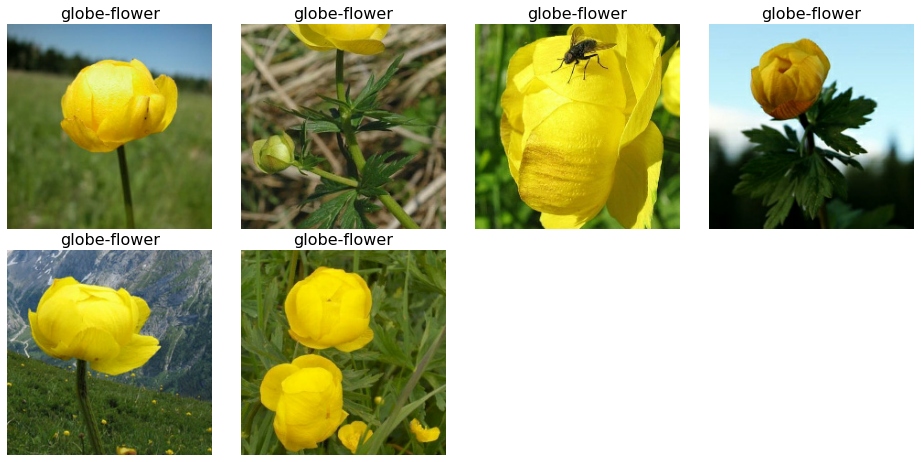

In [21]:
data_root = "../input/tpu-getting-started"

data_path = data_root + '/tfrecords-jpeg-224x224'
val_224 = tf.io.gfile.glob(data_path + '/val/*.tfrec')
train_224 = tf.io.gfile.glob(data_path + '/train/*.tfrec')

display_batch_by_class(val_224, name = class_name, top_n= 10)

In [22]:
vis_imgs = val_results_class.loc[val_results_class.id.isin(['ed3a59a35', '4a6f8b3ad'])]
vis_imgs

pred  label         id    pred_class   label_class
1801    15     77  ed3a59a35  globe-flower         lotus
3042    47     15  4a6f8b3ad     buttercup  globe-flower

In [23]:
def get_images_by_ids(image_ids_search):
    ds_train, ds_valid, ds_test = get_datasets(BATCH_SIZE=batch_size, IMAGE_SIZE=(image_size, image_size), 
                                               RESIZE=None, tpu=False, with_id=True)
    
    imgs_found = []
    imgage_ids_found = []
    labels_found = []
    for imgs, labels, imgs_id in tqdm(ds_valid):
        for img, img_id, label in zip(imgs, imgs_id, labels) :
            if img_id in image_ids_search:
                imgage_ids_found.append(img_id)
                imgs_found.append(img)
                labels_found.append(tf.argmax(label))
                
    return (tf.stack(imgs_found, 0), tf.cast(tf.concat(labels_found, 0), tf.int64)), imgage_ids_found

In [24]:
batch_found,  imgage_ids_found= get_images_by_ids(vis_imgs['id'].values)

Training: <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 104), (None,)), types: (tf.float32, tf.float32, tf.string)>
Validation: <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 104), (None,)), types: (tf.float32, tf.float32, tf.string)>
Test: <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.string)>


58it [00:06,  9.15it/s]


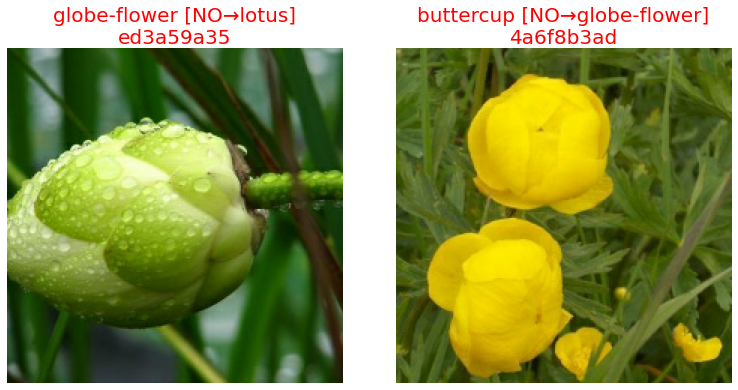

In [25]:
display_batch_of_images(batch_found, predictions=vis_imgs['pred'].values, FIGSIZE=16, image_ids= vis_imgs['id'].values)

> * ed3a59a35 image: Flower shot from the side, and flower seem not to have opened yet. No such type of image exists in the val set. But the training set?
> * 4a6f8b3ad image: the flower seems close to the other globe-flower flowers, in terms of flower and stem leaves. Is buttercup very similar?

15


12753it [00:14, 869.24it/s]


found 21 images and take sample of 10 images


12753it [00:09, 1291.16it/s]


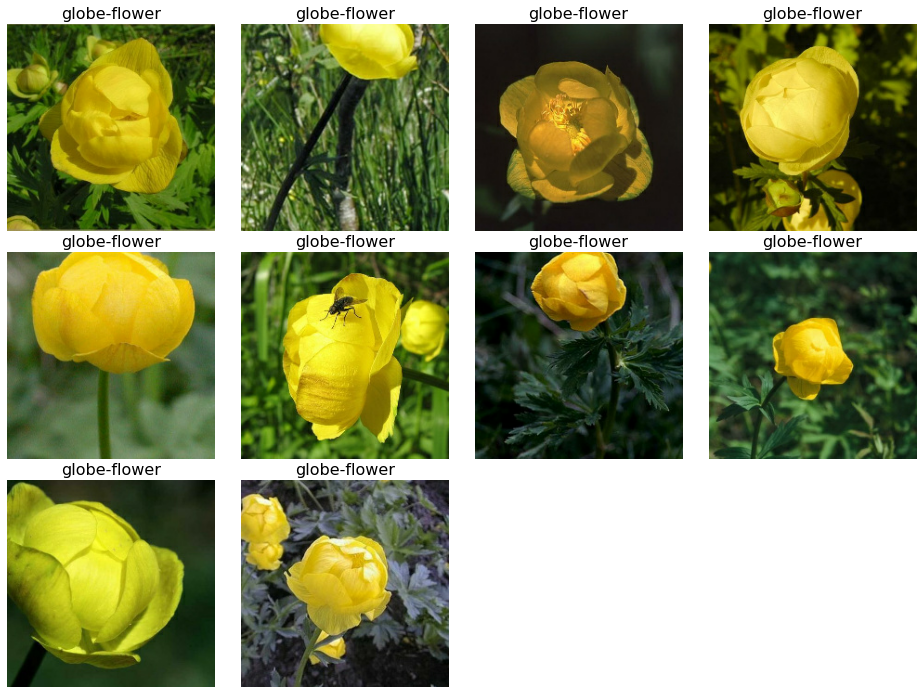

In [26]:
display_batch_by_class(train_224, name = class_name, top_n= 10)

> ed3a59a35 image: Training set does not include does not include such an image. On what is the network focusing on?

77


12753it [00:10, 1268.27it/s]


found 139 images and take sample of 25 images


12753it [00:10, 1226.38it/s]


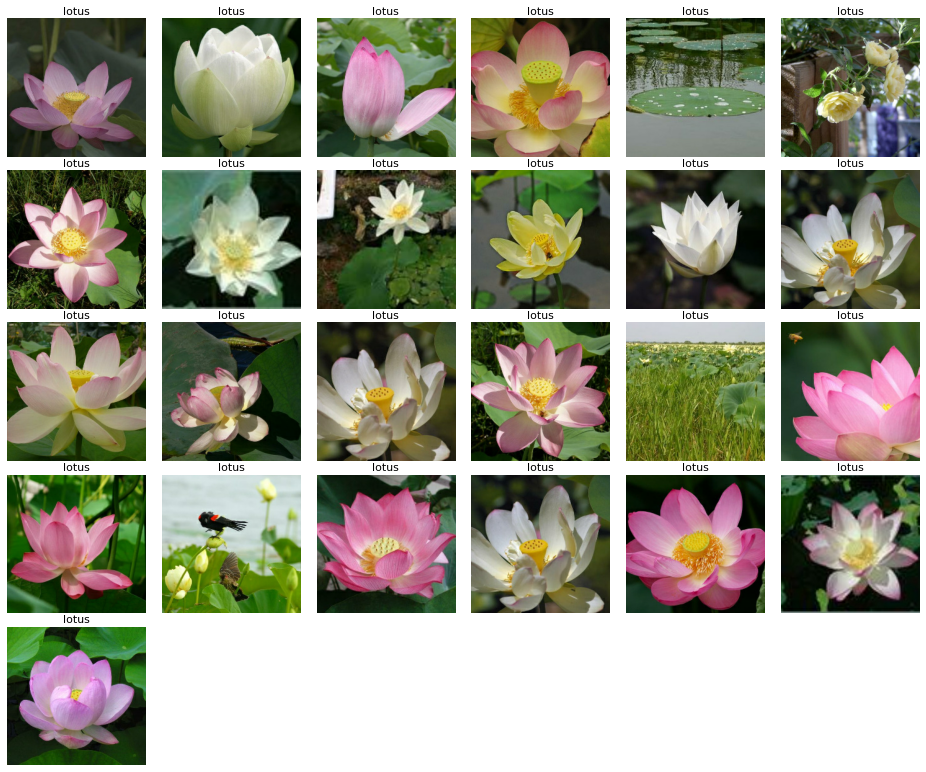

In [27]:
display_batch_by_class(train_224, name = "lotus", top_n= 25)

> Given the form of hte flower in ed3a59a35 image with some of the lotus flowers, it is reasonable to assume it belongs to the class 

47


12753it [00:10, 1270.96it/s]


found 261 images and take sample of 25 images


12753it [00:09, 1283.17it/s]


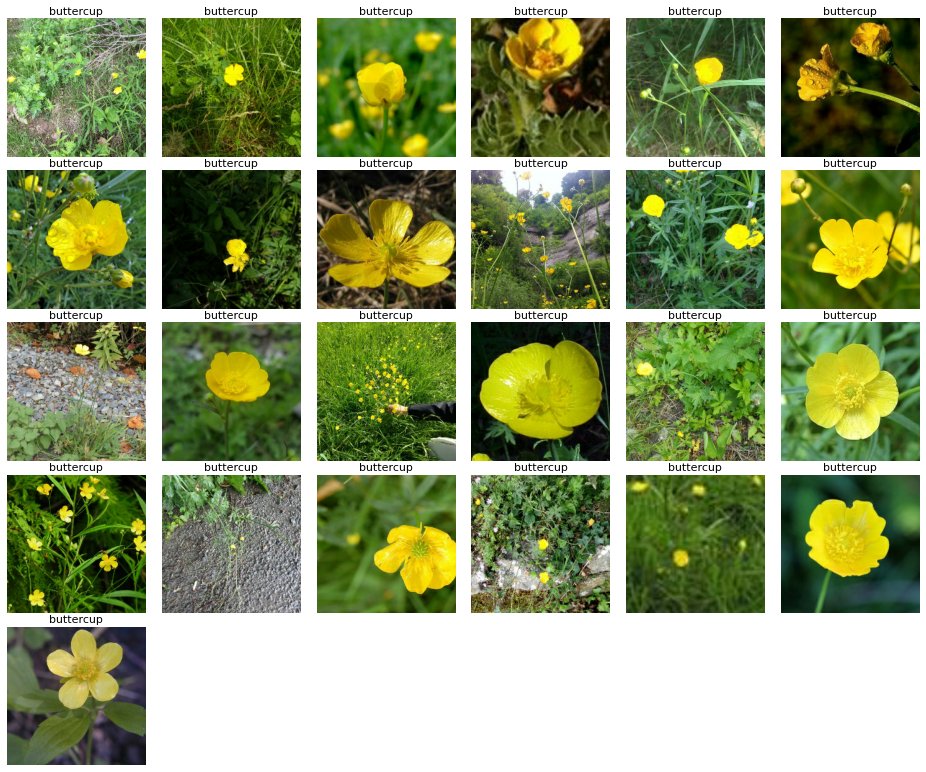

In [28]:
display_batch_by_class(train_224, name = "buttercup", top_n= 25)

> In its closed flower-closed form, buttercup flowers resemble the flower in image 4a6f8b3ad.